# Algorithmes évolutionnaires pour le maillage quadrangulaire

### Objectif: Expérimenter avec les paramètres d'un algorithme évolutionnaire et étudier leur influence

Il nous faut être en mesure de:
- générer les points formant le conour d'une forme et des points intérieurs
- former des maillages à partir de ces points
- calculer la qualité des maillages
- classer les maillages selon leur qualité
- croiser les maillages de différentes manières
- effectuer une mutation sur un maillage

## Exemple sur un polygone convexe

Le code suivant génère des points du contours et intérieurs, et crée un maillage triangulaire.

In [1]:
# -*- coding: utf-8 -*-

###############################################################################
# IMPORTS
###############################################################################

import matplotlib.pyplot as plt       # voir/tracer les figures
import numpy as np                    # manipuler les tableaux de points
import random                         # générer les points dans les figures
from scipy.spatial import Delaunay    # générer les maillages

###############################################################################
# METHODES
###############################################################################

## POLYGONE CONVEXE ##

#Fonction créant un point aléatoirement sur un segment
#Sous-fonction de genererContourPoly et genererCentrePoly
def randomPointSegment(A,B,points):
	#Vérifie si on ne divise pas par zéro pour le coefficient directeur du segment
	coefficient = 0.0 + (points[B][0]-points[A][0])
	if coefficient == 0:
		coefficient = 1
		C=points[A][0]
		D=random.uniform(points[A][1],points[B][1])
	else :
		coefficient = (points[B][1]-points[A][1])/coefficient
		b = points[A][1] - coefficient*points[A][0]
		C=random.uniform(points[A][0],points[B][0])
		D = coefficient*C+b
	return [C,D]

#Fonction de génération des points sur les côtés
def genererContourPoly(nbPointTour,points):
	#Contour
	j=0
	nbPoint = len(points)
	while j < nbPoint:
		if ( j == (nbPoint-1)):
			i = 0
			while i < nbPointTour:
				points = np.concatenate((points,[randomPointSegment(0,j,points)]), axis=0)
				i = i + 1
		else:
			i = 0
			while i < nbPointTour:
				points = np.concatenate((points,[randomPointSegment(j,j+1,points)]), axis=0)
				i = i + 1
		j=j+1
	return points

#Fonction de génération des points 
def genererCentrePoly(nbPointCentre, pointsContour):
  # Ancienne fonction, on la garde au cas où
  """  
  def genererCentrePoly(nbPointCentre, fichierPoints):
    #centre
    points = lireFichierPoints(fichierPoints)
    k=0
    while k < nbPointCentre:
      A= random.randint(0,len(points)-1)
      B= random.randint(0,len(points)-1)
      points = np.concatenate((points,[randomPointSegment(A,B,points)]), axis=0)
      k=k+1
    ecrireFichierPoints(points, fichierPoints)
  """
  ptsCentre = np.zeros(shape=(nbPointCentre, 2))
  for k in range(nbPointCentre):
		A= random.randint(0,len(pointsContour)-1)
		B= random.randint(0,len(pointsContour)-1)
		ptsCentre[k] = [A, B]

  return ptsCentre

# Génère un polygone avec tous les points
def genererPoly(nbPointTour, nbPointCentre, sommets):
    contourPoly = genererContourPoly(nbPointTour, sommets)
    centrePoly = genererCentrePoly(nbPointCentre, contourPoly)
    pointsPoly = np.concatenate((contourPoly, centrePoly), axis=0)
    return pointsPoly

def afficherMaillage(points):
	#Code pour le afficherMaillage
	tri = Delaunay(points)
	plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
	plt.plot(points[:,0], points[:,1], 'o')
	plt.show()

###############################################################################
# Exemple de tracé
###############################################################################

## Paramètres ##
#sommetsPoly est initialisé avec les sommets de la figure
sommetsPoly = np.array([[-20.0, -10.0], [-30.0, 40.0],[-10.0,60.0],[50.0, 10.0],[30.0, -15.0]])

#nombre de points générés sur chaque segment 
nbPointTour = 5

#nombre de points générés dans la figure
nbPointCentre = 20

## Exécution ##
pointsPoly = genererPoly(nbPointTour, nbPointCentre, sommetsPoly)
afficherMaillage(pointsPoly)

<Figure size 640x480 with 1 Axes>

## Exemple sur un cercle discrétisé

Le code suivant génère un polygone régulier pour approximer un cercle unité, des points aléatoirement répartis sur le disque, et un maillage triangulaire.

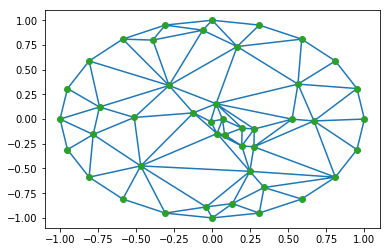

In [2]:
###############################################################################
# IMPORTS
###############################################################################

from math import pi, cos, sin, acos   # générer les points du cercle

###############################################################################
# METHODES
###############################################################################

## CERCLE DISCRET ##

# Génère les points formant le contour du cercle
def genererContourCercle(resolution):
  """
  Entrée: résolution (nbre de pts de la discrétisation du cercle)
  Sortie: numpy.array contenant l'ensemble points de la
  discrétisation du cercle

  On génère les points du contour sur un quadrant de facon régulière, 
  puis on place les symétriques en manipulant les coordonnées:
            _____
          /   |   \ 
        /     |     \ 
      /       |       \ 
    /         |         \ 
   | (-y,x)   |   (x,y)  |
   |----------+----------|
   | (-x,-y)  | (y,-x)   |
    \         |         /
      \       |       / 
        \     |     / 
          \ __|__ /  
  C'est juste pour économiser du temps de calcul sur les cos() et sin(),
  peut-être pas un gain significatif
  """
  
  # On initialise le tableau qui contiendra les points
  ptsContourQuadrant = np.zeros(shape=(resolution*4, 2))

  # On va faire varier l'angle entre 0 et pi/4 (45 deg)
  increment = (pi/2) / resolution
  angle = -increment
  for i in range (resolution):
    angle += increment
    x = cos(angle)
    y = sin(angle)
    ptsContourQuadrant[i] = [x, y]                #top-right
    ptsContourQuadrant[resolution+i] = [-y, x]    #top-left
    ptsContourQuadrant[2*resolution+i] = [-x, -y] #bottom-left
    ptsContourQuadrant[3*resolution+i] = [y, -x]  #bottom-right

  return ptsContourQuadrant

# Sous-fonction de genererInterieurCercle, pour un seul point
def genererPointInterieur(angleMin, angleMax):
  """
  Entrée: intervalle d'angle pour des coordonnées polaires
  Sortie: coordonnées d'un point quelconque sur une portion du disque unité
  """
  angle = random.uniform(angleMin, angleMax)
  distance = random.random()
  return [distance * cos(angle), distance * sin(angle)]

# Génère des points aléatoirement dans un disque
def genererInterieurCercle(nbPointsInterieurs):
  # On initialise le tableau qui contiendra les points avec des zéros
  ptsInterieurs = np.zeros(shape=(nbPointsInterieurs, 2))

  for i in range(nbPointsInterieurs):
    ptsInterieurs[i] = genererPointInterieur(0, 2*pi)

  return ptsInterieurs

# Génere le cercle avec tous ses points
def genererCercle(resolutionQuadrant, nbPointsInterieurs):
    contourCercle = genererContourCercle(resolutionQuadrant)
    centreCercle = genererInterieurCercle(nbPointsInterieurs)
    pointsCercle = np.concatenate((contourCercle, centreCercle), axis=0)
    return pointsCercle
    

###############################################################################
# Exemple de tracé
###############################################################################

## Paramètres ##
# Nombre de points du contour du cercle par quadrant
resolutionQuadrant = 5
# Nombre de points intérieurs au cercle
nbPtsDansCercle = 25

## Exécution ##
pointsCercle = genererCercle(resolutionQuadrant, nbPtsDansCercle)
afficherMaillage(pointsCercle)


## Qualité du maillage triangulaire

Le code suivant permet de donner un critère sur la qualité d'un triangle en considérant l'angle `θ` tel que `θ - 90°` est maximal. La qualité du maillage est la moyenne arithmétique de celle de tous les triangles.

In [3]:
###############################################################################
# METHODES
###############################################################################

# Sous-fonction pour qualiteTriangle
def calculerAngle(a, b, c):
  """
  Entrée: 3 points A[xa, ya], B[xb, yb], C[xc, yc]
  Sortie: angle (AB, AC) en radians

  - On utilise les coordonnées de facon vectorielle: 
  AB = B - A = [xb-xa, yb-ya] etc.
  - On utilise la formule du produit scalaire avec cosinus:
  AB.AC = ||AB||.||AC||.cos(AB,AC) => (AB,AC) = arccos(AB.AC/||AB||.||AC||)
  """
  ab = b - a
  ac = c - a
  prodScal = np.dot(ab,ac)
  prodNorm = np.linalg.norm(ab) * np.linalg.norm(ac)
  return acos(prodScal/prodNorm)


# Qualité d'un seul triangle
def qualiteTriangle(a, b, c):
  """
  Entrée: 3 angles a, b, et c en radians
  Sortie: float dans [0,1] en fonction du max(angle - angle_droit)
  """
  ecartAngle1 = abs(calculerAngle(a,b,c) - pi/2)
  ecartAngle2 = abs(calculerAngle(b,c,a) - pi/2)
  ecartAngle3 = abs(calculerAngle(c,a,b) - pi/2)
  ecartMax = max(ecartAngle1, ecartAngle2, ecartAngle3)

  return ecartMax / (pi/2)

# Qualité d'un ensemble de triangles 
def qualiteMaillage(triangles, points):
  """
  Entrée: 
    - triangles de la forme Delaunay(points).simplices
    - np.array des points du maillage
  Sortie: float dans [0,1]

  Calcule la qualité de tous les triangles et en fait la moyenne arithmétique
  """
  sommeQualite = 0.0

  for triangle in triangles:
    sommeQualite += qualiteTriangle(points[triangle[0]], points[triangle[1]], points[triangle[2]])

  return sommeQualite / len(triangles)

###############################################################################
# TESTS SUR LES EXEMPLES
###############################################################################


maillageExemplePoly = Delaunay(pointsPoly)
maillageExempleCercle = Delaunay(pointsCercle)

print "Qualite du maillage pour le polygone : "
print qualiteMaillage(maillageExemplePoly.simplices, pointsPoly)

print "Qualité du maillage pour le cercle : "
print qualiteMaillage(maillageExempleCercle.simplices, pointsCercle)

Qualite du maillage pour le polygone : 
0.715555324578
Qualité du maillage pour le cercle : 
0.616690898212


## Croisement

On prend 2 maillages parents pour une même forme, on la "coupe" à une frontière. On prend les points d'un côté sur un parent, les points de l'autre côté sur l'autre parent, et on en fait l'union pour obtenir un nouveau maillage.

Qualité parent carré 1 :  0.714999437631
Qualité parent carré 2 :  0.737151532677
Qualité enfant carré :  0.748978918793


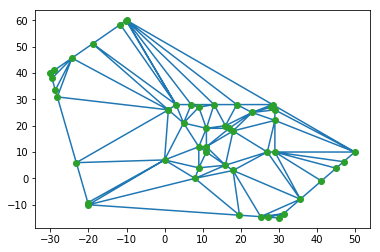

Qualité parent cercle 1 :  0.608392619304
Qualité parent cercle 2 :  0.661926311756
Qualité enfant cercle :  0.656721106288


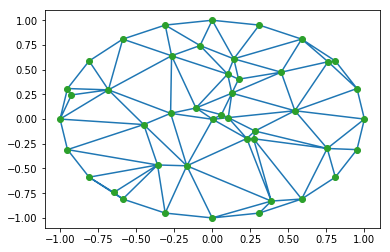

In [4]:
# Croisement gauche-droite
def croisemtGD(pointsParent1, pointsParent2):
  """
  Entrée: 2 ensembles de points correspondant à 2 maillages
  Sortie: 1 ensemble de points correspondant à un maillage
  
  L'enfant aura le même nombre de points que les parents.

  - on prend le point le plus a gauche (x min) et le plus a droite (x max),
  on calcule le barycentre (milieu)
  - on prend tous les points de gauche pour parent1, les autres pour
  parent2
  - on fait l'union, et on ajoute/supprime des points random pour conserver 
  le meme nombre que les parents
  """

  # Calcul de la frontière
  frontiere = (np.amin(pointsParent1, axis=0) + np.amax(pointsParent1, axis=0)) / 2 
  abscisseFrontiere = frontiere[0]

  # On initialise l'enfant à un parent pour être sûr 
  # d'avoir le bon nombre de points
  pointsEnfant = pointsParent1
  i = 0

  for point in pointsParent1:
    if point[0] <= abscisseFrontiere and i < len(pointsEnfant):
      pointsEnfant[i] = point
      i = i + 1

  for point in pointsParent2:
    if point[0] > abscisseFrontiere and i < len(pointsEnfant):
      pointsEnfant[i] = point
      i = i + 1
  
  return pointsEnfant

###############################################################################
# TESTS SUR LES EXEMPLES
###############################################################################

## Polygones convexes ##
# On génère 2 parents
#sommetsCarre = np.array([[-10.0, -10.0], [-10.0, 10.0],[10.0,10.0],[10.0, -10.0]])
sommetsCarre = np.array([[-20.0, -10.0], [-30.0, 40.0],[-10.0,60.0],[50.0, 10.0],[30.0, -15.0]])

pointsCarre1 = genererPoly(nbPointTour, nbPointCentre, sommetsCarre)
maillageCarre1 = Delaunay(pointsCarre1)

pointsCarre2 = genererPoly(nbPointTour, nbPointCentre, sommetsCarre)
maillageCarre2 = Delaunay(pointsCarre2)

# On calcule leur qualité
print "Qualité parent carré 1 : ",qualiteMaillage(maillageCarre1.simplices,pointsCarre1)
print "Qualité parent carré 2 : ",qualiteMaillage(maillageCarre2.simplices,pointsCarre2)

# On les croise et on observe l'enfant
enfantCarre = croisemtGD(pointsCarre1, pointsCarre2)
maillageEnfantCarre = Delaunay(enfantCarre)
print "Qualité enfant carré : ",qualiteMaillage(maillageEnfantCarre.simplices,enfantCarre)
afficherMaillage(enfantCarre)

## Cercles ##
# On génère les 2 parents
pointsCerc1 = genererCercle(resolutionQuadrant, nbPtsDansCercle)
maillageCerc1 = Delaunay(pointsCerc1)

pointsCerc2 = genererCercle(resolutionQuadrant, nbPtsDansCercle)
maillageCerc2 = Delaunay(pointsCerc2)


# On calcule leur qualité
print "Qualité parent cercle 1 : ",qualiteMaillage(maillageCerc1.simplices,pointsCerc1)
print "Qualité parent cercle 2 : ",qualiteMaillage(maillageCerc2.simplices,pointsCerc2)

# On les croise et on observe l'enfant
enfantCerc = croisemtGD(pointsCerc1, pointsCerc2)
maillageEnfantCerc = Delaunay(enfantCerc)
print "Qualité enfant cercle : ",qualiteMaillage(maillageEnfantCerc.simplices,enfantCerc)
afficherMaillage(enfantCerc)


## Conservation des données

Pour faciliter le tri des maillages en fonction de leur qualité et la conservation des résultats, on définit une classe contenant 3 attributs:
- ensemble de points (`numpy.array`)
- maillage triangulaire (`Delaunay(points)`)
- qualité du maillage

On pourra alors trier les objets selon leur qualité, puis les enregistrer dans un fichier texte.

In [5]:
###############################################################################
# CLASSE
###############################################################################

## Définition ##
class Maillage(object):
    def __init__(self, points):
        self.points = points
        self.tri = Delaunay(points).simplices
        self.qualite = qualiteMaillage(self.tri, points)
        
    ## Méthodes ##
    # Ecrit les points du maillage dans un fichier .txt
    def ecrireFichierPoints(self, fichier):
	w=0
	while w<len(self.points):
		temp0 = str(self.points[w][0])
		temp1 = str(self.points[w][1])
		point = "["+temp0+","+temp1+"]\n"
		fichier.write(point)
		w=w+1
        
    # Ecrit la qualité du maillage dans un fichier .txt
    def ecrireFichierQualite(self, fichier):
        fichier.write(str(maillage.qualite)+'\n')
        
###############################################################################
# METHODES
###############################################################################

    
# Lit un fichier .txt contenant des points et les met dans un np.array
# On utilisera cette fonction pour exploiter les résultats
def lireFichierPoints(filename, nbPtsParMaillage):
	points = np.array([[0.0, 0.0]])
	fichier = open(filename, "r")
	for ligne in fichier:
		temp0 = ""
		temp1 = ""
		indice = 0
		for c in ligne:
			if (indice == 0 and (c == "-" or c == "." or c.isdigit() == True )):
				temp0 = temp0+c
			elif c == ",":
				indice = 1
			elif (indice == 1 and (c == "-" or c == "." or c.isdigit() == True)):
				temp1 = temp1+c
		points = np.concatenate((points,[[float(temp0),float(temp1)]]), axis=0)
	points = np.delete(points,0,0)
	fichier.close()
	return np.split(points,nbPtsParMaillage,axis=0)

def lireFichierQualite(filename):
    fichier = open(filename, "r")
    qualites = [q for q in fichier]
    fichier.close()
    return qualites

###############################################################################
# EXEMPLE
###############################################################################


taillePopulation = 10

# On génère une population de maillages dans une liste
exemplePopulation = [
    Maillage(points=genererCercle(resolutionQuadrant, nbPtsDansCercle)) 
    for i in range(taillePopulation)
]

# On la trie par ordre décroissant de qualité (1er élément: meilleur)
exemplePopulation.sort(key=lambda maillage: maillage.qualite, reverse=True)

# On écrit les résultats dans un fichier
testPoints = open("testPoints.txt", "w")
testQualite = open("testQualite.txt", "w")
for maillage in exemplePopulation:
    maillage.ecrireFichierPoints(testPoints)
    maillage.ecrireFichierQualite(testQualite)
testPoints.close()
testQualite.close()

# On peut lire ces résultats

variablePoints = lireFichierPoints("testPoints.txt", taillePopulation)
testQualite = lireFichierQualite("testQualite.txt")

# Points et qualité du 3e maillage
print variablePoints[2]
print testQualite[2]

[[ 1.          0.        ]
 [ 0.95105652  0.30901699]
 [ 0.80901699  0.58778525]
 [ 0.58778525  0.80901699]
 [ 0.30901699  0.95105652]
 [-0.          1.        ]
 [-0.30901699  0.95105652]
 [-0.58778525  0.80901699]
 [-0.80901699  0.58778525]
 [-0.95105652  0.30901699]
 [-1.         -0.        ]
 [-0.95105652 -0.30901699]
 [-0.80901699 -0.58778525]
 [-0.58778525 -0.80901699]
 [-0.30901699 -0.95105652]
 [ 0.         -1.        ]
 [ 0.30901699 -0.95105652]
 [ 0.58778525 -0.80901699]
 [ 0.80901699 -0.58778525]
 [ 0.95105652 -0.30901699]
 [-0.20479897 -0.39648314]
 [-0.5399846   0.56874956]
 [-0.47791329  0.45338385]
 [-0.15099763  0.55165433]
 [ 0.1219431   0.07989765]
 [-0.01632622  0.40409914]
 [ 0.22015963  0.92182369]
 [ 0.48988255 -0.80720335]
 [-0.00157261 -0.10243153]
 [ 0.22003494  0.32007711]
 [-0.30513523  0.45051858]
 [ 0.8506556  -0.24923574]
 [-0.44705027  0.67092456]
 [-0.02562877  0.06615746]
 [ 0.77491628  0.17104098]
 [ 0.28090819 -0.07646229]
 [ 0.9481094  -0.11109983]
 

## Algorithme évolutionnaire

In [6]:
"""
pseudo-code time

# Init population
population = np.array()
for i in range(maxPop):
  tempPoints = genererFigure()
  population[i] = Maillage(points=tempPoints)


for g in range(nbGenerations)
  trier(population)
  couper(population, bestRange)

  # 1er passage ou on enregistre les meilleurs
  for i in range(bestRange):
    save(population[i].points, i, g)
    save(population[i].qualite, i, g)

  # 2e passage ou on croise les meilleurs et on les append
  for 2i in range(bestRange):
    population.append(croisemtGD(population[i],population[i+1]))
    population.append(croisemtHB(population[i],population[i+1]))
    population.append(croisemtRando(population[i],population[i+1]))
    
bleh
"""

'\npseudo-code time\n\n# Init population\npopulation = np.array()\nfor i in range(maxPop):\n  tempPoints = genererFigure()\n  population[i] = Maillage(points=tempPoints)\n\n\nfor g in range(nbGenerations)\n  trier(population)\n  couper(population, bestRange)\n\n  # 1er passage ou on enregistre les meilleurs\n  for i in range(bestRange):\n    save(population[i].points, i, g)\n    save(population[i].qualite, i, g)\n\n  # 2e passage ou on croise les meilleurs et on les append\n  for 2i in range(bestRange):\n    population.append(croisemtGD(population[i],population[i+1]))\n    population.append(croisemtHB(population[i],population[i+1]))\n    population.append(croisemtRando(population[i],population[i+1]))\n    \nbleh\n'